#### Math from fipy example description:

Spinodal decomposition can be described by the "Cahn-Hilliard"
equation (also known as "conserved Ginsberg-Landau" or "model B" of Hohenberg & Halperin)

$\frac{\partial \phi}{\partial t}
   = \nabla\cdot D \nabla\left( \frac{\partial f}{\partial \phi}   - \epsilon^2 \nabla^2 \phi\right)$
   
where $\phi$ is a conserved order parameter, possibly representing
alloy composition or spin. The double-well free energy function $f = (a^2/2) \phi^2 (1 - \phi)^2$ penalizes states with intermediate values of $\phi$
between 0 and 1. The gradient energy term $\epsilon^2 \nabla^2\phi$,
on the other hand, penalizes sharp changes of $\phi$.
These two competing effects result in the segregation
of $\phi$ into domains of 0 and 1, separated by abrupt, but
smooth, transitions. The parameters $a$ and $\epsilon$ determine the relative
weighting of the two effects and $D$ is a rate constant.


For FiPy, we need to perform the partial derivative
$\partial f/\partial \phi$
manually and then put the equation in the canonical
form by decomposing the spatial derivatives
so that each FiPy Term is of a single, even order:

   $\frac{\partial \phi}{\partial t}
    = \nabla\cdot D a^2 \left[ 1 - 6 \phi \left(1 - \phi\right)\right] \nabla \phi- \nabla\cdot D \nabla \epsilon^2 \nabla^2 \phi$
    
FiPy would automatically interpolate
$D a^2 \left[ 1 - 6 \phi \left(1 - \phi\right)\right]$
onto the faces, where the diffusive flux is calculated, but we obtain
somewhat more accurate results by performing a linear interpolation from
phi at cell centers to PHI at face centers.

In [5]:
import pathlib
from fipy import CellVariable, Grid3D, Viewer, GaussianNoiseVariable, Grid2D, TransientTerm, DiffusionTerm, DefaultSolver
from fipy.tools import numerix
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
### Define paths
notebookPath = pathlib.Path.cwd()
exportPath = notebookPath.joinpath('fipy_morphs/2D')

### Colormap
cmap = plt.cm.YlGnBu_r.copy()

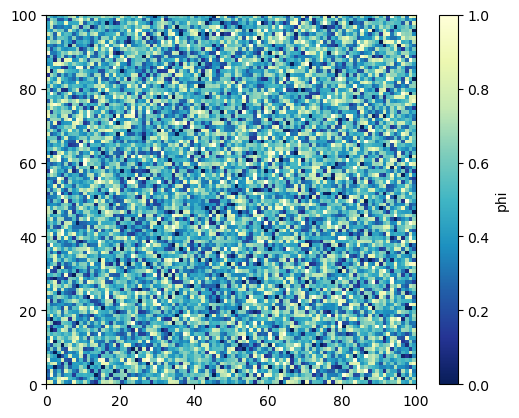

In [7]:
### Define mesh
nx = ny = 100
# nz = 10
dx = dy = 1.
# dz = 1.
# mesh = Grid3D(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz)
mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)

### Define volume fraction map
phi = CellVariable(mesh=mesh, name='phi')
phi.setValue(GaussianNoiseVariable(mesh=mesh, mean=0.5, variance=0.05))

### Set equation 
PHI = phi.arithmeticFaceValue
D = 1.
a = 1.
epsilon = 1.
eq = (TransientTerm()
      == DiffusionTerm(coeff=D * a**2 * (1 - 6 * PHI * (1 - PHI)))
      - DiffusionTerm(coeff=(D, epsilon**2)))

### Initialize viewer
viewer = Viewer(vars=(phi,), datamin=0., datamax=1.)
elapsed = 0
viewer.cmap = cmap

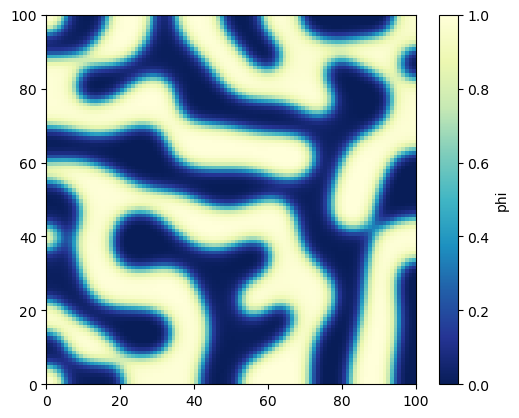

500 time steps in 17.7 seconds!


In [8]:
target = 500
time_0 = time.time()

while elapsed < target:
    if elapsed < 4:
        dt = 1
    elif elapsed < 10:
        dt = 2
    elif elapsed < 100:
        dt = 5
    elif elapsed < 500:
        dt = 10
    else: 
        dt=20
    elapsed += dt  
    eq.solve(phi, dt=dt, solver=DefaultSolver(precon=None))
    viewer.plot()
    # for elapsed_value in (100, 200, 300, 400, 500, 600):
    #     if elapsed==elapsed_value:
    #         print(f'{elapsed} time steps in {np.round((time.time() - time_0), 1)} seconds!')

print(f'{elapsed} time steps in {np.round((time.time() - time_0), 1)} seconds!')

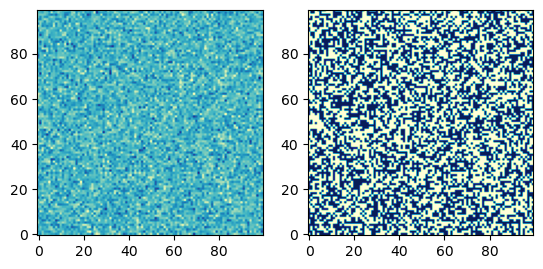

In [4]:
### Numpy:
data = phi.copy().value.reshape((nx, ny))
data_binary = data.copy()
data_binary[data<0.5] = 0
data_binary[data>=0.5] = 1

np.savetxt(exportPath.joinpath(f'{nx}x{ny}pix_{int(dx*nx)}x{int(dy*ny)}size_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}.txt'), data)
np.savetxt(exportPath.joinpath(f'{nx}x{ny}pix_{int(dx*nx)}x{int(dy*ny)}size_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}_binary.txt'), data_binary)


fig, axs = plt.subplots(1,2)
axs[0].imshow(data, origin='lower', cmap=cmap)
axs[1].imshow(data_binary, origin='lower', cmap=cmap)
plt.show()

In [12]:
# def gen_2d(nxy=100, dxy=1., mean=0.5, D=1., a=1., eps=1., steps=500, savePath=savePath, counter=1):
#     """
#     Generate a 2D BHJ morphology based on the Cahn-Hilliard Eqn. using a generic free energy term that penalizes 
#     values of phi between 0 and 1. 

#     Inputs: nxy: number of pixels 
#             dxy: size of each pixel
#             mean: starting average value for the generated 2D mesh
#             D, a, eps: terms for the Cahn-Hilliard Eqn. (Diffusion Rate, free energy term, deg. of mixing term)
#             steps: number of time steps to simulate
#             savePath: path in which to create output directory

#     Outputs: new directory inside output directory named according to the above parameters, inside:
#              the morphology model as a basic numpy array .txt file
#              png images of the morphology model at various timesteps leading up to the target number of steps
#     """
#     # ### Create folder to save morphology model
#     # directory = False
#     # counter = counter
#     # while directory == False:
#     #     try: 
#     #         modPath = savePath.joinpath(f'D{D}_a{a}_eps{eps}_{nxy}pix_{int(nxy*dxy)}size_{mean}m_{steps}steps_{counter}')
#     #         modPath.mkdir(parents=True, exist_ok=True)
#     #         directory = True
#     #     except FileExistsError:
#     #         counter += 1

#     ### Create mesh
#     mesh = Grid2D(nx=nxy, ny=nxy, dx=dxy, dy=dxy)

#     ### Define volume fraction map
#     phi = CellVariable(mesh=mesh, name='phi')
#     phi.setValue(GaussianNoiseVariable(mesh=mesh, mean=mean, variance=0.05))

#     ### Set equation 
#     PHI = phi.arithmeticFaceValue
#     eq = (TransientTerm()
#         == DiffusionTerm(coeff=D * a**2 * (1 - 6 * PHI * (1 - PHI)))
#         - DiffusionTerm(coeff=(D, eps**2)))
    
#     ### Generate morphology:
#     elapsed = 0

#     viewer = Viewer(vars=(phi,), datamin=0., datamax=1.)
#     elapsed = 0
#     viewer.cmap = cmap

#     # data = phi.copy().globalValue.reshape((nxy, nxy))
#     # np.savetxt(modPath.joinpath(f'BHJ_{elapsed}steps.txt'), data)
#     # plt.imshow(data, origin='lower', cmap=cmap, extent=(0, int(nxy*dxy), 0, int(nxy*dxy)))
#     # plt.colorbar(label='phi')
#     # plt.savefig(modPath.joinpath(f'BHJ_{elapsed}steps.png'))
#     # plt.close('all')

#     time_0 = time.time()
#     target = steps
#     while elapsed < target:
#         if elapsed < 6:
#             dt = 1
#         elif elapsed < 30:
#             dt = 2
#         elif elapsed < 100:
#             dt = 5
#         elif elapsed < 500:
#             dt = 10
#         else: 
#             dt = 20
#         elapsed += dt  
#         eq.solve(phi, dt=dt, solver=DefaultSolver(precon=None))
#         if elapsed in (10, 30, 50, 100, 200, 300, 400, 500, target):
#             print(f'{elapsed} time steps in {np.round((time.time() - time_0), 1)} seconds!')
#             viewer.plot()
#             # data = phi.copy().globalValue.reshape((nxy, nxy))
#             # np.savetxt(modPath.joinpath(f'BHJ_{elapsed}steps.txt'), data)
#             # plt.imshow(data, origin='lower', cmap=cmap, extent=(0, int(nxy*dxy), 0, int(nxy*dxy)))
#             # plt.colorbar(label='phi')
#             # plt.savefig(modPath.joinpath(f'BHJ_{elapsed}steps.png'))
#             # plt.close('all')

#     print(f'{elapsed} time steps in {np.round((time.time() - time_0), 1)} seconds!')


# if __name__ == '__main__':
#     nxy = 100
#     dxy = 0.8
#     mean = 0.5
#     D = a = eps = 1.
#     steps = 600
#     counter = 2

#     gen_2d(nxy=nxy, dxy=dxy, mean=mean, D=D, a=a, eps=eps, steps=steps, counter=counter)


### WORKS HERE, WHY NOT IN ALPINE!?!?!?!?

In [ ]:
# Extract and reshape data for Matplotlib visualization
data = phi.copy().value.reshape((nz, nx, ny))

fig, axs = plt.subplots(2,5)
fig.set(tight_layout=True, size_inches=(12,6))
axs=axs.flatten()
for iz in range(data.shape[0]):
    axs[iz].imshow(data[iz,:,:], vmin=0, vmax=1, origin='lower', cmap=plt.cm.jet)
    axs[iz].set(title=f'z={iz+1}')

In [ ]:
# Extract and reshape data for Matplotlib visualization
data_binary = data.copy()
data_binary[data<0.5] = 0
data_binary[data>=0.5] = 1

fig, axs = plt.subplots(2,5)
fig.set(tight_layout=True, size_inches=(12,6))
axs=axs.flatten()
for iz in range(data_binary.shape[0]):
    axs[iz].imshow(data_binary[iz,:,:], vmin=0, vmax=1, origin='lower', cmap=plt.cm.viridis)
    axs[iz].set(title=f'z={iz+1}')
    
np.save(exportPath.joinpath(f'{nx}x{ny}x{nz}vox_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}.npy'), data)
np.save(exportPath.joinpath(f'{nx}x{ny}x{nz}vox_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}_binary.npy'), data_binary)